# Adversarial Search: Playing Dots and Boxes


## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play the game Dots and Boxes:

> "Dots and Boxes is a pencil-and-paper game for two players. The game starts with an empty grid of dots. Usually two players take turns adding a single horizontal or vertical line between two unjoined adjacent dots. A player who completes the fourth side of a 1x1 box earns one point and takes another turn. A point is typically recorded by placing a mark that identifies the player in the box, such as an initial. The game ends when no more lines can be placed. The winner is the player with the most points. The board may be of any size grid." (see [Dots and Boxes on Wikipedia](https://en.wikipedia.org/wiki/Dots_and_Boxes))

You can play Dots and Boxes [here](https://www.math.ucla.edu/~tom/Games/dots&boxes.html).

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

### Your code/answer goes here.
- initial state = The board is empty with no lines.
- Actions = add a line between two dots. Gets all the possible actions an agent can make
- Transition model = result(s,a) = s'  
    - draws a line that results in the board having two new dots connected with a line. Will also determine who won a completed box
- Tests for the terminal state = determines if the game is over or not hence if all the possible moves have been completed
- Utility for terminal state = determines if a player has won, lost, or tied the game 

How big is the state space? Give an estimate and explain it.

### Your code/ answer goes here.
state space = 2^(number of horizontal dots) * 2^(number of vertical dots)

This is my estimate because there can either be a line drawn or not drawn on each horizontal/vertical dot. Because the space doesn't have to be a perfect square you multiply the states of the number of horizontal dots by all the states of the number of vertical dots.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

### Your code/ answer goes here.
The game tree will be much bigger than the state space as the same state can be gotten to in different subtrees.
The number of nodes in teh subtree of NxN board is shown with this formula: 1 * N * (N * (N-1) * (N * (N-1) * (N-2)...N!)

## Task 2: Game Environment and Random Agent [30 point]

You need to think about a data structure to represent the board meaning he placed lines and who finished what box. There are many options. Let's represent the board using a simple dictionary where `n` and `m` represents the number of dots horizontaly and vertically, respectively. Everybody needs to use the same representation so we can let agents play against each other later. 

In [307]:
board = {
    'n': 4,  ### hoizontal dots
    'm': 4,  ### vertical dots
    'score1': 0, ### score for player 1
    'score-1': 0  ### score for player 2
}

def draw_line(board, orientation, row, col, player):
    """
    Place a line on an exiting board.
       
    Parameters
    ----------
    board: dict
        the board
    orientation: str
        either 'h' or 'v' for horizontal or vertical
    row, col: int
        index of the starting dot for the line (starting with 0)
    
    """
    
    if orientation not in ['h', 'v']:
        return False
        
    if row < 0 or col < 0:
        return False
        
    if row >= board['n'] + (orientation == 'h') or col >= board['m'] + (orientation == 'v'):
        return False
        
    if (orientation, row, col, 1) in board or (orientation, row, col, -1) in board:
        return False
            
    board[(orientation, row, col)] = True
    # check if square is full
    if orientation == 'h':
        if row == 1:
            if ('v', row, col) in board and ('h', row+1, col) in board and ('v', row, col+1) in board and (row, col) not in board:
                # print('Player {} scores!'.format(player))
                board[(row, col)] = player
                board['score{}'.format(player)] += 1
        elif row == board['m']:
            if ('v', row-1, col) in board and ('h', row-1, col) in board and ('v', row-1, col+1) in board and (row-1, col) not in board:
                # print('Player {} scores!'.format(player))
                board[(row-1, col)] = player
                board['score{}'.format(player)] += 1
        else:
            if ('v', row, col) in board and ('h', row+1, col) in board and ('v', row, col+1) in board and (row,col) not in board:
                # print('Player {} scores!'.format(player))
                board[(row, col)] = player
                board['score{}'.format(player)] += 1
            if ('v', row-1, col) in board and ('h', row-1, col) in board and ('v', row-1, col+1) in board and (row-1,col) not in board:
                # print('Player {} scores!'.format(player))
                board[(row-1, col)] = player
                board['score{}'.format(player)] += 1
    elif orientation == 'v':
        if col == 1:
            if ('h', row, col) in board and ('v', row, col+1) in board and ('h', row+1, col) in board and (row, col) not in board:
                # print('Player {} scores!'.format(player))
                board[(row, col)] = player
                board['score{}'.format(player)] += 1
        elif col == board['m']:
            if ('h', row, col-1) in board and ('v', row, col-1) in board and ('h', row+1, col-1) in board and (row, col-1) not in board:
                # print('Player {} scores!'.format(player))
                board[(row, col-1)] = player
                board['score{}'.format(player)] += 1
        else:
            if ('h', row, col) in board and ('v', row, col+1) in board and ('h', row+1, col) in board and (row,col) not in board:
                # print('Player {} scores!'.format(player))
                board[(row, col)] = player
                board['score{}'.format(player)] += 1
            if ('h', row, col-1) in board and ('v', row, col-1) in board and ('h', row+1, col-1) in board and (row,col-1) not in board:
                # print('Player {} scores!'.format(player))
                board[(row, col-1)] = player
                board['score{}'.format(player)] += 1


    return True



Write code to display the board. **Bonus point: Post your visualization code with an example output to the discussion board. The best visualization will earn you bonus participation points in this class.**

In [309]:
# Your code/ answer goes here.
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

def show_board(board):
    cmap = colors.ListedColormap(['white', 'pink', 'blue', 'green', 'yellow'])
    hight = board['n']
    width = board['m']
    # adds an extra space between dots for the line
    np_arr = np.zeros((hight * 2 - 1, width * 2 -1 ))
    h = width*2-1
    for i in range(len(np_arr.flat)):
        if i % 2 == 0:
            np_arr.flat[i] = 1
    for i in range(h):
        if i % 2 == 1:
            np_arr[:,i] = 0
    # draw line
    for key in board:
        if key[0] == 'h':
            np_arr[(key[1]-1)*2, (key[2]-1)*2+1] = 2
        elif key[0] == 'v':
            np_arr[(key[1]-1)*2+1, (key[2]-1)*2] = 2
    # draw score
    for key in board:
        if key != 'n' and key != 'm' and key != 'score1' and key != 'score-1' and key[0] != 'h' and key[0] != 'v':
            row = (key[0]-1) * 2 + 1
            col = (key[1]-1) * 2 + 1
            if board[key] == 1:
                np_arr[row, col] = 3
            elif board[key] == -1:
                np_arr[row, col] = 4
    plt.imshow(np_arr, cmap=cmap, norm = colors.BoundaryNorm(list(range(cmap.N + 1)), cmap.N))
    plt.show()

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

__Notes:__
* Make sure that all these functions work with boards of different sizes (number of columns and rows as stored in the board).
* The result function evaluates if the player closed a box and needs to store that information on the board. Add elements of the form `(row,col): player` to the board dictionary. `row` and `col` are the coordinates for the box and `player` is +1 or -1 representing the player. For example `(0,0): -1` means that the top-left box belongs to the other player. 

In [310]:
# gets list of all possible moves for a player
def actions(board):
    """
    Return a list of possible actions.
    """
    width = board['m']
    hight = board['n']
    actions = []
    completed = []
    for key in board:
        if key[0] == 'h' or key[0] == 'v':
            completed.append((key[0],key[1], key[2]))
    for i in range(1, hight):
        for j in range(1, width):
            if ('h', i, j) not in completed:
                actions.append(('h',i,j))
            if ('v', i, j) not in completed:
                actions.append(('v', i,j))
    for i in range(1, width):
        if ('h', hight, i) not in completed:
            actions.append(('h', hight, i))
    for i in range(1, hight):
        if ('v', i, width) not in completed:
            actions.append(('v', i, width))
    return actions

In [4]:
def terminal(board):
    """
    Return True if the game is over, False otherwise.
    """
    moves = actions(board)
    if len(moves) == 0:
        return True
    return False
    

In [5]:
def check_win(board, player=1):
    """
    Return the value of this final state to player. Returns None if final state has not been reached.
    """
    moves = actions(board)
    if len(moves) == 0:
        if player==1:
            if board['score1'] > board['score-1']:
                return 'win'
            elif board['score1'] < board['score-1']:
                return 'lose'
            else:
                return 'tie'
        else:
            if board['score1'] < board['score-1']:
                return 'win'
            elif board['score1'] > board['score-1']:
                return 'lose'
            else:
                return 'tie'
    return None

In [6]:
def utility(board, player=1):
    """
    Return the value of this final state to player.
    """
    g= check_win(board, player)
    if g == 'win':
        return 1
    elif g == 'lose':
        return -1
    elif g == 'tie':
        return 0
    else:
        return None

In [8]:
def result(s, p, a):
    """
    Return the state that results from making move p in state s on action a.
    """
    newBoard = s.copy()
    draw_line(newBoard, a[0], a[1], a[2], p)
    return newBoard

In [9]:
def empty_board(x = 4, y = 4):
    """
    Return an empty board.
    """
    board = {'n': x, 'm': y, 'score1': 0, 'score-1': 0}
    return board

In [336]:
#check if the action has closed a box
def check_closed(board, action, player=1):
    if action is None:
        return False
    board = board.copy()
    if action not in board:
        print('action not in board')
        return False
    # score = (action[1], action[2])
    # if score in board:
    #     return True
    if action[0] == 'v':
        if  ('v', action[1], action[2]+1) in board and ('h', action[1]-1, action[2]) in board and ('h', action[1], action[2]) in board:
            return True
        if ('v', action[1], action[2]-1) in board and ('h', action[1], action[2]-1) in board and ('h', action[1]-1, action[2]-1) in board:
            return True
    elif action[0] == 'h':
        if ('v', action[1]+1, action[2]) in board and ('h', action[1]+1, action[2]) in board and ('v', action[1]+1, action[2]+1) in board:
          
            return True
        if ('h', action[1]-1, action[2]) in board and ('v', action[1], action[2]) in board and ('v', action[1], action[2]+1) in board:
         
            return True

    return False

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on by the environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [133]:
# Your code/ answer goes here.
# agent that plays randomly
def random_player(board, player=None):
    """
    Return a random move.
    """
    moves = actions(board)
    move = moves[np.random.randint(len(moves))]
    move = (move[0], move[1], move[2])
    return {'move': move}

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [202]:
# Your code/ answer goes here.
# switch players
def switch_player(number, a1, a2):
    if number == 1:
        return -1, a2
    else:
        return 1, a1
# play a game between two agents
def play_game(state, agent1, agent2):
    """
    Play a game between two agents by alternately soliciting them
    to select a move and applying it in the game.
    """
    # state = empty_board(3, 3)
    player, fun = 1, agent1
    while not terminal(state):
        # show_board(state)
        move = fun(state, player)
        a = move['move']
        state = result(state, player, a)
        player, fun = switch_player(player, agent1, agent2)
    return state

In [348]:
p1_wins = 0
p2_wins = 0
for i in range(1000):
    board = empty_board()
    b = play_game(board, random_player, random_player)
    if b['score1'] > b['score-1']:
        p1_wins += 1
    elif b['score1'] < b['score-1']:
        p2_wins += 1
    else:
        p1_wins += 0.5
        p2_wins += 0.5
print('Number of wins after 1000 games:')
print('p1 wins:', p1_wins)
print('p-1 wins:', p2_wins)

Number of wins after 1000 games:
p1 wins: 353
p-1 wins: 647


## Task 3: Minimax Search with Alpha-Beta Pruning [30 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for larger board may be too large. You can experiment with smaller boards.

In [406]:
def alpha_beta_search(board, player=1):
    board = board.copy()
    value, move = max_value(board, player, -np.inf, np.inf)
    return {'move': move, 'value': value}

def max_value(state, player, alpha, beta, last_move = None):
    if terminal(state):
        return utility(state, player), None
    v = -np.inf
    move = None
    # check to see if previous action closed a box
    if check_closed(state, last_move):
        v2, a2 = min_value(state, player, alpha, beta, None)
        if v2 > v:
            v = v2
            move = None
        if v >= beta:
            return v, move
        alpha = max(alpha, v)
    else:
        for a in actions(state):
            v2, a2= min_value(result(state, player, a), player, alpha, beta, a)
            if v2 > v:
                v = v2
                move = a
                alpha = max(alpha, v)
            if v >= beta:
                return v, move
            alpha = max(alpha, v)
    return v, move

def min_value(state, player, alpha, beta, last_move = None):
    if terminal(state):
        return utility(state, player), None
    
    v = np.inf
    move = None

    if check_closed(state, last_move): # check to see if previous action closed a box
        v2, a2 = max_value(state, player, alpha, beta, None)
        if v2 < v:
            v = v2
            move = None
        if v <= alpha:
            return v, move
        beta = min(beta, v)
    else:
        for a in actions(state):
            v2, a2 = max_value(result(state, other(player), a), player, alpha, beta, a)
            if v2 < v:
                v = v2
                move = a
                beta = min(beta, v)
            if v <= alpha:
                return v, move
            beta = min(beta, v)
    return v, move

In [292]:
def other(player):
    """
    Returns the opponent of a player.
    """
    if player == 1:
        return -1
    else:
        return 1

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

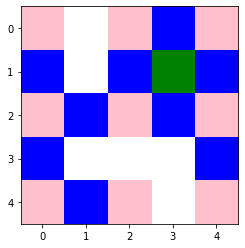

{'move': ('v', 2, 2), 'value': 1}

In [349]:
b = empty_board(3,3)
draw_line(b, "v", 1, 1, 1)
draw_line(b, "v", 1, 2, -1)
draw_line(b, "v", 1, 3, 1)
draw_line(b, "h", 1, 2, 1)
draw_line(b, "h", 2, 2, 1)
draw_line(b, "v", 2, 3, 1)
draw_line(b, "v", 2, 1, 1)
draw_line(b, "h", 2, 1, -1)
draw_line(b, "h", 3, 1, 1)
show_board(b)
alpha_beta_search(b, -1)

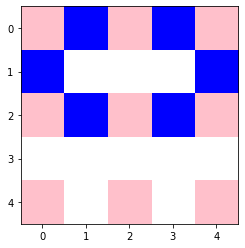

{'move': ('v', 1, 2), 'value': 1}

In [352]:
b = empty_board(3,3)
draw_line(b, "v", 1, 1, 1)
draw_line(b, 'h', 1, 1, -1)
draw_line(b, 'h', 1, 2, 1)
draw_line(b, 'h', 2, 1, -1)
draw_line(b, 'h', 2, 2, 1)
draw_line(b, 'v', 1, 3, 1)

show_board(b)
alpha_beta_search(b, 1)

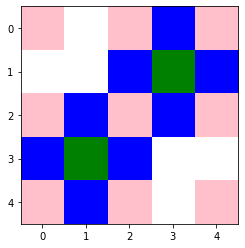

{'move': ('h', 1, 1), 'value': -1}

In [355]:
b = empty_board(3,3)

draw_line(b, 'v', 2, 1, -1)
draw_line(b, 'h', 3, 1, 1)
draw_line(b, 'v', 2, 2, -1)
draw_line(b, 'h', 2, 1, 1)
draw_line(b, 'h', 1, 2, -1)
draw_line(b, 'h', 2, 2, 1)
draw_line(b, 'v', 1, 2, -1)
draw_line(b, 'v', 1, 3, 1)

show_board(b)
alpha_beta_search(b, -1)

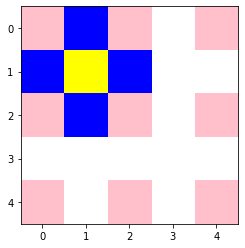

{'move': ('h', 1, 2), 'value': 0}

In [358]:
b = empty_board(3,3)
draw_line(b, "v", 1, 1, 1)
draw_line(b, "v", 1, 2, -1)
draw_line(b, 'h', 1, 1, 1)
draw_line(b, 'h', 2, 1, -1)
show_board(b)
alpha_beta_search(b, 1)

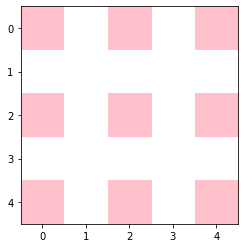

{'move': ('h', 1, 1), 'value': 0}

In [335]:
b = empty_board(3,3)
show_board(b)
alpha_beta_search(b, 1)

How long does it take to make a move? Start with a smaller board make the board larger. What is the largest board you can solve?

It doesn't take very long to make a move if there aren't that many possible moves left. The size of the board doesn't matter as much meaning i could have a 5x5 board but if it is filled out except for 3 available moves it won't take long.

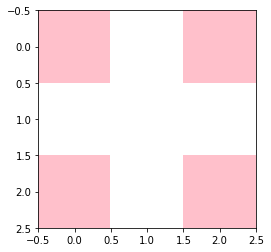


CPU times: user 164 µs, sys: 0 ns, total: 164 µs
Wall time: 165 µs


{'move': ('h', 1, 1), 'value': -1}

In [359]:
# Your code/ answer goes here.
b = empty_board(2,2)
show_board(b)
print()
%time alpha_beta_search(b, 1)

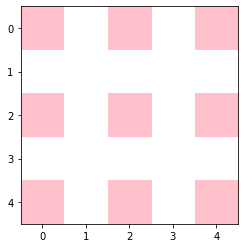


CPU times: user 8.34 s, sys: 66.9 ms, total: 8.41 s
Wall time: 7.96 s


{'move': ('h', 1, 1), 'value': 0}

In [360]:
b = empty_board(3,3)
show_board(b)
print()
%time alpha_beta_search(b, 1)

In [ ]:
# 4x4 empty board takes too long
b = empty_board()
show_board(b)
print()
%time alpha_beta_search(b, 1)

### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

My move ordering strategy orders the moves by choosing the edge moves first then the rest. I also made a random ordering.

In [112]:
def ordering(board):
    moves = actions(board)
    ordered = []
    for move in moves:
        if move[0] == 'v' and (move[1] == 1 or move[1] == board['n']):
            ordered.append(move)
        if move[0] == 'h' and (move[1] == 1 or move[1] == board['m']):
            ordered.append(move)
    for move in moves:
        if move not in ordered:
            ordered.append(move)
    return ordered


In [156]:
import random
def random_ordering(board):
    moves = actions(board)
    random.shuffle(moves)
    return moves

In [374]:
def alpha_beta_search_MO(board, player=1, order_fun=ordering):
    board = board.copy()
    value, move = max_value(board, player, -np.inf, np.inf, order_fun)
    return {'move': move, 'value': value}

def max_value(state, player, alpha, beta, order_fun, last_move = None):
    if terminal(state):
        return utility(state, player), None
    v = -np.inf
    move = None

    if check_closed(state, last_move):
        v2, a2 = min_value(state, player, alpha, beta, order_fun)
        if v2 > v:
            v = v2
            move = None
        if v >= beta:
            return v, move
        alpha = max(alpha, v)
    else:
        for a in actions(state):
            v2, a2= min_value(result(state, player, a), player, alpha, beta, order_fun, a)
            if v2 > v:
                v = v2
                move = a
                alpha = max(alpha, v)
            if v >= beta:
                return v, move
            alpha = max(alpha, v)
    return v, move

def min_value(state, player, alpha, beta, order_fun, last_move = None):
    if terminal(state):
        return utility(state, player), None
    
    v = np.inf
    move = None

    if check_closed(state, last_move):
        v2, a2 = max_value(state, player, alpha, beta, order_fun)
        if v2 < v:
            v = v2
            move = None
        if v <= alpha:
            return v, move
        beta = min(beta, v)
    else:
        for a in actions(state):
            v2, a2 = max_value(result(state, other(player), a), player, alpha, beta, order_fun, a)
            if v2 < v:
                v = v2
                move = a
                beta = min(beta, v)
            if v <= alpha:
                return v, move
            beta = min(beta, v)
    return v, move

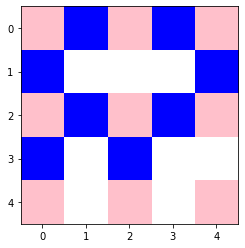

In [370]:
b = empty_board(3,3)
draw_line(b, "v", 1, 1, 1)
draw_line(b, 'h', 1, 1, -1)
draw_line(b, 'h', 1, 2, 1)
draw_line(b, 'h', 2, 1, -1)
draw_line(b, 'h', 2, 2, 1)
draw_line(b, 'v', 1, 3, 1)
draw_line(b, 'v', 2, 1, -1)
draw_line(b, 'v', 2, 2, 1)
show_board(b)


In [377]:
print()
%time alpha_beta_search_MO(b, 1, random_ordering)


CPU times: user 392 µs, sys: 2 µs, total: 394 µs
Wall time: 396 µs


{'move': ('v', 1, 2), 'value': 1}

In [378]:
print()
%time alpha_beta_search_MO(b, 1, ordering)


CPU times: user 389 µs, sys: 6 µs, total: 395 µs
Wall time: 399 µs


{'move': ('v', 1, 2), 'value': 1}

In [379]:
print()
%time alpha_beta_search(b, 1)


CPU times: user 390 µs, sys: 8 µs, total: 398 µs
Wall time: 401 µs


{'move': ('v', 1, 2), 'value': 1}

In [380]:
import pandas as pd
df = pd.DataFrame(columns=['ordering', 'random_ordering', 'no_ordering'])
df.loc[0] = ['396 us', '399 us', '401 us']
df

,ordering,random_ordering,no_ordering
0,396 us,399 us,401 us


### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

### Your code/ answer goes here.
One possibility is you could fill out all the spaces in the board that don't create a 3/4ths of a box before you start the minimax with alpha-beta pruning. If you are playing a game you aren't going to draw the 3rd line of the box because that means your opponent will get a point next turn. If you skip through all this early game you will have a more filled out board where the minimax search can use it's strategy and not take forever to figure out a move. 

To do this you can make a pretty simple reflex agent: 
1.  it will check if there are any spaces to complete a box, if that's true it will do that move.
2.  it will check for places where there are 3 out of the 4 boxes and avoid those spaces
3. If there is an empty board it will choose a random space

When you combine this with a minimax search, you would most likely use this agent for around the first 75% of moves allowing the search to take over so it won't take nearly as long of a time.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [412]:
# Your code/ answer goes here.
p1_wins = 0
p2_wins = 0
for i in range(100):
    board = empty_board(3,3)
    b = play_game(board, random_player, alpha_beta_search)
    if b['score1'] > b['score-1']:
        p1_wins += 1
    elif b['score1'] < b['score-1']:
        p2_wins += 1
    else:
        p1_wins += 0.5
        p2_wins += 0.5
print('Number of wins after 100 games:')
print('p1 wins:', p1_wins)
print('p-1 wins:', p2_wins)

Number of wins after 1000 games:
p1 wins: 15.0
p-1 wins: 85.0


After 100 games you can see the alpha_beta_search wins 85% of the time which is significantly better than a random player.

## Task 4: Heuristic Alpha-Beta Tree Search [30 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [138]:
# Your code/ answer goes here.
# heurisitic based on number of moves to win
def eval_func(board, player):
    """
    Return a heuristic value for the current board.
    """
    u = utility(board, player)
    if u is not None: return u, True
    size = board['n'] * board['m']
    p = board['score{}'.format(player)]
    other = board['score{}'.format(-player)]
    score = (p - other) / size
    return score, False

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [405]:
def alpha_beta_search_cutoff(board, player=1, cutoff=None):
    board = board.copy()
    value, move = max_value(board, player, -np.inf, np.inf, 0, cutoff)
    return {'move': move, 'value': value}

def max_value(state, player, alpha, beta, depth, cutoff, last_move = None):
    v, terminal = eval_func(state, player)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): 
            alpha, beta = v, v
        return v, None
    v = -np.inf
    move = None

    if check_closed(state, last_move):
        v2, a2 = min_value(state, player, alpha, beta, depth, cutoff)
        if v2 > v:
            v = v2
            move = None
        if v >= beta:
            return v, move
        alpha = max(alpha, v)
    else:
        for a in actions(state):
            v2, a2= min_value(result(state, player, a), player, alpha, beta, depth+1, cutoff, a)
            if v2 > v:
                v = v2
                move = a
                alpha = max(alpha, v)
            if v >= beta:
                return v, move
            alpha = max(alpha, v)
    return v, move

def min_value(state, player, alpha, beta, depth, cutoff, last_move = None):
    v, terminal = eval_func(state, player)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): 
            alpha, beta = v, v
        return v, None
    
    v = np.inf
    move = None

    if check_closed(state, last_move):
        v2, a2 = max_value(state, player, alpha, beta, depth, cutoff)
        if v2 < v:
            v = v2
            move = None
        if v <= alpha:
            return v, move
        beta = min(beta, v)
    else:
        for a in actions(state):
            v2, a2 = max_value(result(state, other(player), a), player, alpha, beta, depth+1, cutoff, a)
            if v2 < v:
                v = v2
                move = a
                beta = min(beta, v)
            if v <= alpha:
                return v, move
            beta = min(beta, v)
    return v, move

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

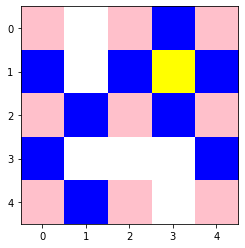

{'move': ('v', 2, 2), 'value': 1}

In [387]:
# Your code/ answer goes here.
b = empty_board(3,3)
draw_line(b, "v", 1, 1, 1)
draw_line(b, "v", 1, 2, -1)
draw_line(b, "v", 1, 3, 1)
draw_line(b, "h", 1, 2, 1)
draw_line(b, "h", 2, 2, -1)
draw_line(b, "v", 2, 3, 1)
draw_line(b, "v", 2, 1, 1)
draw_line(b, "h", 2, 1, -1)
draw_line(b, "h", 3, 1, 1)
show_board(b)
alpha_beta_search_cutoff(b, 1, 3)

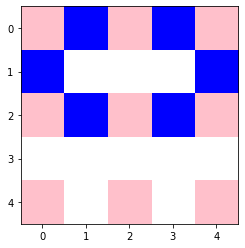

{'move': ('v', 1, 2), 'value': 0.2222222222222222}

In [390]:
b = empty_board(3,3)
draw_line(b, "v", 1, 1, 1)
draw_line(b, 'h', 1, 1, -1)
draw_line(b, 'h', 1, 2, 1)
draw_line(b, 'h', 2, 1, -1)
draw_line(b, 'h', 2, 2, 1)
draw_line(b, 'v', 1, 3, 1)

show_board(b)
alpha_beta_search_cutoff(b, 1,3)

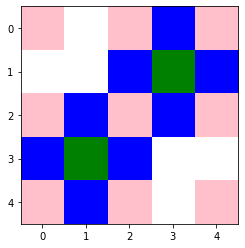

{'move': ('h', 1, 1), 'value': -0.1111111111111111}

In [392]:
b = empty_board(3,3)

draw_line(b, 'v', 2, 1, -1)
draw_line(b, 'h', 3, 1, 1)
draw_line(b, 'v', 2, 2, -1)
draw_line(b, 'h', 2, 1, 1)
draw_line(b, 'h', 1, 2, -1)
draw_line(b, 'h', 2, 2, 1)
draw_line(b, 'v', 1, 2, -1)
draw_line(b, 'v', 1, 3, 1)

show_board(b)
alpha_beta_search_cutoff(b, -1, 3)

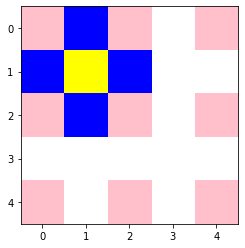

{'move': ('h', 2, 2), 'value': 0.0}

In [393]:
b = empty_board(3,3)
draw_line(b, "v", 1, 1, 1)
draw_line(b, "v", 1, 2, -1)
draw_line(b, 'h', 1, 1, 1)
draw_line(b, 'h', 2, 1, -1)
show_board(b)
alpha_beta_search_cutoff(b, 1, 5)

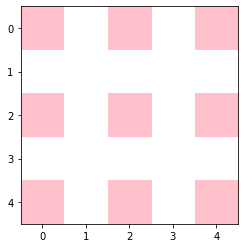

{'move': ('h', 1, 1), 'value': 0.0}

In [394]:
b = empty_board(3,3)
show_board(b)
alpha_beta_search_cutoff(b, 1, 5)

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [398]:
for i in range(4, 11):
    b = empty_board(i,4)
    print()
    print('{}x4'.format(i))
    %time alpha_beta_search_cutoff(b, 1, 5)


4x4
CPU times: user 95.8 ms, sys: 2 ms, total: 97.8 ms
Wall time: 97.1 ms

5x4
CPU times: user 229 ms, sys: 2.62 ms, total: 231 ms
Wall time: 231 ms

6x4
CPU times: user 467 ms, sys: 3.91 ms, total: 471 ms
Wall time: 474 ms

7x4
CPU times: user 857 ms, sys: 8.22 ms, total: 865 ms
Wall time: 872 ms

8x4
CPU times: user 1.44 s, sys: 12.3 ms, total: 1.45 s
Wall time: 1.45 s

9x4
CPU times: user 2.29 s, sys: 19.3 ms, total: 2.31 s
Wall time: 2.31 s

10x4
CPU times: user 3.48 s, sys: 32.1 ms, total: 3.51 s
Wall time: 3.52 s


### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [399]:
def heuristic1_player(board, player = 1):
    return alpha_beta_search_cutoff(board, cutoff = 2, player = player)
def heuristic2_player(board, player = 1):
    return alpha_beta_search_cutoff(board, cutoff = 6, player = player)

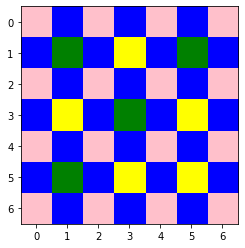

In [402]:
# Your code/ answer goes here.
b = empty_board()
game = play_game(b, heuristic1_player, heuristic2_player)
show_board(game)

## Tournament task [+1 to 5% bonus on your course grade; will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above. 

In [247]:
# Your code/ answer goes here.
def playout(state, action, player = 1):
    """Perfrom a random playout starting with the given action on the fiven board 
    and return the utility of the finished game."""
    state = result(state, player, action)
    current_player = other(player)
    
    while(True):
        # reached terminal state?
        u = utility(state, player)
        if u is not None: 
            return u
        
        # we use a random playout policy
        moves = actions(state)
        i = np.random.choice(len(moves))
        a = moves[i]
        state = result(state, current_player, a)
        #print(state)
        
        # switch between players
        current_player = other(current_player)

# playour for action of horizontal line at 1,1
board = empty_board()
print(playout(board, ('h', 1, 1)))
print(playout(board, ('h', 1, 1)))
print(playout(board, ('h', 1, 1)))
print(playout(board, ('h', 1, 1),-1))

1
-1
-1
-1


In [248]:
def playouts(board, action, player = 1, N = 100):
    """Perform N playouts following the given action for the given board."""
    return [ playout(board, action, player) for i in range(N) ]

In [246]:
import math
DEBUG = 0
def pmcs(board, N = 100, player = 1):
    """Pure Monte Carlo Search. Returns the action that has the largest average utility.
    The N playouts are evenly divided between the possible actions."""
    global DEBUG
    
    acts = actions(board)
    n = math.floor(N/len(acts))
    if DEBUG >= 1: print(f"Actions: {acts} ({n} playouts per action)")
    
    ps = { i : np.mean(playouts(board, i, player, N = n)) for i in acts }
    if DEBUG >= 1: display(ps)
        
    action = max(ps, key=ps.get)
    return action

In [238]:
board = empty_board(3,3)
%time print(pmcs(board))

print()
%time print(pmcs(board, N = 1000))

('h', 2, 2)
CPU times: user 15.2 ms, sys: 5.06 ms, total: 20.2 ms
Wall time: 18.5 ms

('v', 1, 2)
CPU times: user 141 ms, sys: 29 ms, total: 170 ms
Wall time: 150 ms


### Test boards

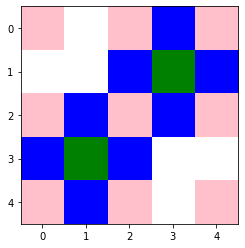

('v', 1, 1)
CPU times: user 14.3 ms, sys: 2.1 ms, total: 16.4 ms
Wall time: 4.9 ms


In [250]:
b = empty_board(3,3)

draw_line(b, 'v', 2, 1, -1)
draw_line(b, 'h', 3, 1, 1)
draw_line(b, 'v', 2, 2, -1)
draw_line(b, 'h', 2, 1, 1)
draw_line(b, 'h', 1, 2, -1)
draw_line(b, 'h', 2, 2, 1)
draw_line(b, 'v', 1, 2, -1)
draw_line(b, 'v', 1, 3, 1)

show_board(b)
%time print(pmcs(b))

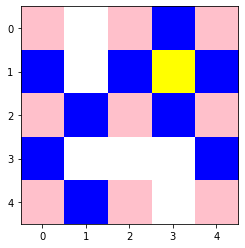

('h', 1, 1)
CPU times: user 11.4 ms, sys: 824 µs, total: 12.2 ms
Wall time: 3.51 ms


In [249]:
b = empty_board(3,3)
draw_line(b, "v", 1, 1, 1)
draw_line(b, "v", 1, 2, -1)
draw_line(b, "v", 1, 3, 1)
draw_line(b, "h", 1, 2, 1)
draw_line(b, "h", 2, 2, -1)
draw_line(b, "v", 2, 3, 1)
draw_line(b, "v", 2, 1, 1)
draw_line(b, "h", 2, 1, -1)
draw_line(b, "h", 3, 1, 1)
show_board(b)
%time print(pmcs(b))

In [251]:
b = empty_board(3,3)
%time print(pmcs(b))

('v', 2, 2)
CPU times: user 14.9 ms, sys: 4.94 ms, total: 19.8 ms
Wall time: 16.2 ms


#### Summing it up
The PMCS algorithm gives the best move in all the tests. Also it is extremely quick giving me a move for an empty 3x3 board way faster than alpha beta pruning search. 

### Best First Move

How would you determine what the best first move for a standard board ($5 \times 5$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

### Your code/ answer goes here.
To figure out the best first move for a 5x5 board. I'll run playouts for each possible first move. I'll use Pure monte carlo search algorithm to find the one with the best average utility.

The monte carlo search with 50,000 playours determined that the best first move for a 5x5 board is ('v', 1, 2)

In [254]:
b = empty_board(5,5)
%time print(pmcs(b, N = 1000))

('v', 3, 4)
CPU times: user 1.17 s, sys: 30.6 ms, total: 1.2 s
Wall time: 1.18 s


In [257]:
b = empty_board(5,5)
%time print(pmcs(b, N = 10000))

('v', 4, 2)
CPU times: user 11.4 s, sys: 74.1 ms, total: 11.5 s
Wall time: 11.5 s


In [258]:
b = empty_board(5,5)
%time print(pmcs(b, N = 50000))

('v', 1, 2)
CPU times: user 57.5 s, sys: 462 ms, total: 58 s
Wall time: 57.8 s
